# Прогнозирование биологического ответа молекул

In [1]:
# импортируем необходимые для работы библиотеки
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_validate, train_test_split
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
import optuna

c:\Users\alpis\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('data/_train_sem09 (1).csv') # импортируем датасет
data.tail()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
3746,1,0.033300,0.506409,0.10,0.0,0.209887,0.633426,0.297659,0.376124,0.727093,...,0,0,0,0,0,0,0,0,0,0
3747,1,0.133333,0.651023,0.15,0.0,0.151154,0.766505,0.170876,0.404546,0.787935,...,0,0,1,0,1,0,1,0,0,0
3748,0,0.200000,0.520564,0.00,0.0,0.179949,0.768785,0.177341,0.471179,0.872241,...,0,0,0,0,0,0,0,0,0,0
3749,1,0.100000,0.765646,0.00,0.0,0.536954,0.634936,0.342713,0.447162,0.672689,...,0,0,0,0,0,0,0,0,0,0
3750,0,0.133333,0.533952,0.00,0.0,0.347966,0.757971,0.230667,0.272652,0.854116,...,0,0,0,0,0,0,0,0,0,0


c:\Users\alpis\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Activity', ylabel='count'>

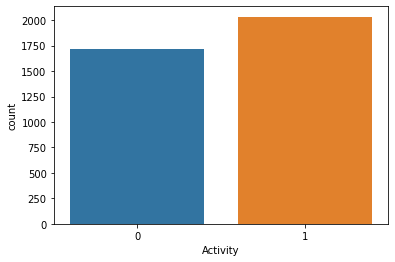

In [3]:
sns.countplot(data['Activity']) # проверим сбалансированность классов

Дисбаланс классов небольшой. Но всё же при разделении выборки на тренировочную и тестовую используем параметр stratify для сохранения соотношения целевого признака.

In [4]:
# разбиваем датасет на тренировочную и тестовую выборки со стратификацией по целевому признаку
random_state = 1
X = data.drop(['Activity'], axis=1)
y = data['Activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

Перед подбором гиперпараметров моделей логистической регрессии и случайного леса с помощью базовых и продвинутых методов оптимизации зафиксируем метрику f1 со значениями гиперпараметров моделей по умолчанию.

In [5]:
# создадим объект класса логистическая регрессия. Согласно условию задания, количество итераций ограничим 50.
# обучим модель с использованием кросс-валидации на 5 фолдах
log_reg = LogisticRegression(max_iter=50)
kf = KFold()
lr_cv_metrics = cross_validate(
    estimator=log_reg,
    X=X,
    y=y,
    cv=kf,
    scoring='f1'
)
lr_cv_metrics

c:\Users\alpis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\alpis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

{'fit_time': array([0.4396677 , 0.35096431, 0.35881186, 0.38901281, 0.3739078 ]),
 'score_time': array([0.01391959, 0.01478219, 0.01398087, 0.0131855 , 0.01392984]),
 'test_score': array([0.77373974, 0.7601476 , 0.77672209, 0.78688525, 0.77435265])}

In [6]:
print('LogisticRegression со значениями гиперпараметров по умолчанию.')
print("f1_score на тестовом наборе данных: {:.2f}".format(np.mean(lr_cv_metrics['test_score'])))

LogisticRegression со значениями гиперпараметров по умолчанию.
f1_score на тестовом наборе данных: 0.77


In [7]:
# аналогичную процедуру проведём для модели случайного леса
r_forest = RandomForestClassifier()
rf_cv_metrics = cross_validate(
    estimator=r_forest,
    X=X,
    y=y,
    cv=kf,
    scoring='f1'
)
rf_cv_metrics

{'fit_time': array([1.53886414, 1.40459132, 1.5650866 , 1.37486577, 1.49225521]),
 'score_time': array([0.04120922, 0.03842998, 0.03796744, 0.03399324, 0.03131604]),
 'test_score': array([0.82703322, 0.80798005, 0.78824969, 0.82233503, 0.8097561 ])}

In [8]:
print('RandomForestClassifier со значениями гиперпараметров по умолчанию.')
print("f1_score на тестовом наборе данных: {:.2f}".format(np.mean(rf_cv_metrics['test_score'])))

RandomForestClassifier со значениями гиперпараметров по умолчанию.
f1_score на тестовом наборе данных: 0.81


Получено два значения f1_score, от которых будем отталкиваться при дальнейшем подборе гиперпараметров моделей:
- 0.77 для LogisticRegression
- 0.81 для RandomForestClassifier

### <center> LogisticRegression + GridSearchCV

In [9]:
#зададим сетку гиперпараметров модели
lr_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet' 'none'], # тип регуляризации
    'solver': ['lbfgs', 'sag', 'saga', 'liblinear'], # алгоритм оптимизации
    'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1] # уровень силы регурялизации
}

grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(random_state=random_state, max_iter=50),
    param_grid=lr_param_grid,
    n_jobs=-1,
    cv=5
)

%time grid_search_lr.fit(X_train, y_train)
y_test_pred = grid_search_lr.predict(X_test)
print('f1_score на тестовом наборе данных: {:.2f}'.format(f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_lr.best_params_))

c:\Users\alpis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
210 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\alpis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\alpis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\alpis\AppData\Local\Programs\Pytho

CPU times: total: 3.5 s
Wall time: 42.8 s
f1_score на тестовом наборе данных: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


c:\Users\alpis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


После подбора гиперпараметров с использованием GridSearchCV далось улучшить метрику f1_score для модели логистической регрессии с 0.77 до 0.79.

### <center> LogisticRegression + RandomizedSearchCV

In [10]:
from sklearn.model_selection import RandomizedSearchCV

# зададим возможные гиперпараметры модели
lr_param_distributions = {
              'penalty': ['l1', 'l2', 'elasticnet'] , # тип регуляризации
              'solver': ['lbfgs', 'saga' 'liblinear'], # алгоритм оптимизации
               'C': [0.01, 0.03, 0.05, 0.07, 0.1] # уровень силы регурялизации
}

rand_search_lr = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=random_state, max_iter=50), 
    param_distributions=lr_param_distributions, 
    cv=5, 
    n_jobs = -1,
    n_iter=50
)  

%time rand_search_lr.fit(X_train, y_train)
y_test_pred = rand_search_lr.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(rand_search_lr.best_params_))

c:\Users\alpis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 30 is smaller than n_iter=50. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\alpis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
125 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\alpis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_tra

CPU times: total: 2.41 s
Wall time: 7.41 s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.03}


c:\Users\alpis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Значение целевой метрики в сравнении с GridSearchCV не изменилось, однако нам удалось значительно сократить время, затрачиваемое на подбор оптимальных гиперпараметров.

### <center> RandomForest + Hyperopt

In [11]:
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
from sklearn.model_selection import cross_val_score

# зададим пространство поиска гиперпараметров
space = {
    'n_estimators' : hp.quniform('n_estimators', 50, 201, 30,),
    'min_samples_leaf' : hp.quniform('min_samples_leaf', 3, 7, 1),
    'max_depth' : hp.quniform('max_depth', 10, 26, 5)    
}

In [12]:
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, n_iter=50, random_state=random_state):
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
    model = RandomForestClassifier(**params, random_state=random_state)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    
    return -score

In [13]:
%time
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, 
          space=space,
          max_evals=30, # максимальное количество итераций
          algo=tpe.suggest,
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(42)
         )

print("Наилучшие значения гиперпараметров {}".format(best))

CPU times: total: 0 ns
Wall time: 0 ns
100%|██████████| 30/30 [00:58<00:00,  1.95s/trial, best loss: -0.8079853461437644]
Наилучшие значения гиперпараметров {'max_depth': 15.0, 'min_samples_leaf': 3.0, 'n_estimators': 120.0}


In [14]:
# рассчитаем точность для тестовой выборки
model = RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.82


После подбора гиперпараметров для модели случайного леса нам также удалось улучшить целевую метрику с 0.81 до 0.82.

### <center>  Optuna + RandomForest

In [15]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 5, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)

  model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    random_state=random_state)
  
  model.fit(X_train, y_train)
  score = f1_score(y_train, model.predict(X_train))

  return score

In [16]:
%%time

study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=30)

[I 2022-11-10 14:34:29,871] A new study created in memory with name: RandomForestClassifier
[I 2022-11-10 14:34:31,900] Trial 0 finished with value: 0.914742997845491 and parameters: {'n_estimators': 199, 'max_depth': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.914742997845491.
[I 2022-11-10 14:34:33,654] Trial 1 finished with value: 0.9920343137254902 and parameters: {'n_estimators': 127, 'max_depth': 29, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9920343137254902.
[I 2022-11-10 14:34:34,878] Trial 2 finished with value: 0.8980716253443526 and parameters: {'n_estimators': 114, 'max_depth': 23, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.9920343137254902.
[I 2022-11-10 14:34:36,215] Trial 3 finished with value: 0.9243441122635754 and parameters: {'n_estimators': 120, 'max_depth': 28, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.9920343137254902.
[I 2022-11-10 14:34:38,223] Trial 4 finished with value: 0.9770992366412213 and parameters: {'n_e

CPU times: total: 1min 2s
Wall time: 1min 3s


In [17]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

Наилучшие значения гиперпараметров {'n_estimators': 194, 'max_depth': 30, 'min_samples_leaf': 1}


In [18]:
# рассчитаем точность для тестовой выборки
model = RandomForestClassifier(**study.best_params,random_state=random_state)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.83


Optuna помогла ещё немного улучшить целевую метрику f1_score для модели случайного леса с 0.82 до 0.83. 

# Выводы:
Мы познакомились с методами оптимизации гиперпараметров на примере GridSearchCV, RandomizedSearchCV, Hyperopt и Optuna. Во всех случаях удалось улучшить метрику f1 с гиперпараметрами моделей по умолчанию.
1. Для модели случайного леса максимальные значения метрики F1 были получены с применением библиотеки оптимизвции гиперпараметров Optuna: f1 = 0.83.
2. Для модели логистической регрессии значение метрики F1 составило 0.79 как с применением библиотеки оптимизации гиперпараметров GridSearchCV, так и с библиотекой RandomizedSearchCV. Однако GridSearchCV удалось найти оптимальные гиперпараметры модели за 42.3 сек., а RandomizedSearchCV - за 7.41 сек.